In [1]:
# Project: CrimesDelits
# Creation Date: 2023-10-11
# History:
######################################################################################################################################################
#   DATE            AUTHOR      VERSION     ACTION
#   2023-10-11      LLEG        1.0.0       Creation

import time
import logging

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
from prophet import Prophet
from sklearn.metrics import r2_score

from utils.log_config import Logging
from utils.constant import Constant
from utils.functions import download_file, read_xlsx

In [1]:
# load logging config
Logging.create_log_folder()
Logging.load_logging_config("./conf/logging.json")
log = logging.getLogger(__name__)

In [1]:
starting_time = time.time()
log.debug('Start')

In [1]:
download_file(url=Constant.DATA_URL, filepath=Constant.DATA_FILE)
download_file(url=Constant.DOCUMENTATION_URL, filepath=Constant.DOCUMENTATION_FILE)
download_file(url=Constant.INSTRUCTIONS_URL, filepath=Constant.INSTRUCTIONS_FILE)

[INFO] 2023-11-27 19:47:46,267 utils.functions.download_file() 34: crimes-delits.xlsx file already exists
[INFO] 2023-11-27 19:47:46,267 utils.functions.download_file() 34: documentation.docx file already exists
[INFO] 2023-11-27 19:47:46,268 utils.functions.download_file() 34: instructions.pdf file already exists


In [1]:
dict_df = read_xlsx(Constant.DATA_FILE)

In [1]:
total = dict((i, 0) for i in range(1, 108))

for df in dict_df.values():
    for index, _ in df.iterrows():
        total[index] += df.loc[index, :].sum()

total = dict(sorted(total.items(), key=lambda item: item[1], reverse=True))

for key, value in total.items():
    print(f"index: {key}, total: {value}")

index: 43, total: 3342820.0
index: 37, total: 2586123.0
index: 7, total: 2436894.0
index: 91, total: 2238067.0
index: 27, total: 2157769.0
index: 42, total: 1873313.0
index: 57, total: 1727518.0
index: 32, total: 1317596.0
index: 107, total: 1248000.0
index: 67, total: 1121396.0
index: 12, total: 1073885.0
index: 38, total: 1028597.0
index: 35, total: 1017991.0
index: 68, total: 998464.0
index: 29, total: 674818.0
index: 89, total: 654977.0
index: 41, total: 634959.0
index: 33, total: 615282.0
index: 30, total: 595857.0
index: 90, total: 560966.0
index: 36, total: 554876.0
index: 13, total: 515233.0
index: 26, total: 468801.0
index: 52, total: 437378.0
index: 25, total: 414864.0
index: 44, total: 390547.0
index: 66, total: 357914.0
index: 74, total: 349581.0
index: 73, total: 330563.0
index: 53, total: 312936.0
index: 63, total: 300613.0
index: 72, total: 274907.0
index: 56, total: 217308.0
index: 28, total: 186696.0
index: 69, total: 173555.0
index: 49, total: 150690.0
index: 39, tota

In [1]:
na_sum = 0
for key in dict_df.keys():
    na_sum += dict_df[key].loc[Constant.CHOSEN_INDEX, :].isna().sum()

print(f"NaN sum for {Constant.CHOSEN_INDEX}: {na_sum}")

NaN sum for 57: 0


In [1]:
df = pd.DataFrame({key: value.T.groupby(level='Départements').sum().T.loc[Constant.CHOSEN_INDEX, :] for key, value in dict_df.items()}).T
df.columns.name = None
df.fillna(0, inplace=True)

df.insert(0, 'year', np.int_)
df.insert(1, 'services', np.int_)
df.insert(2, 'total', np.int_)

for index, row in df.iterrows():
    df.loc[index, 'year'] = index[-4:]
    df.loc[index, 'services'] = index[9:11]
    df.loc[index, 'total'] = row.drop(['year', 'services', 'total']).sum()
    
df.sort_values('year', inplace=True)
df.reset_index(inplace=True, drop=True)

df

,year,services,total,01,02,03,04,05,06,07,...,95,971,972,973,974,976,978,986,987,988
0,2012,PN,122094.0,461.0,734.0,337.0,167.0,153.0,2912.0,202.0,...,4312.0,494.0,780.0,366.0,358.0,81.0,0.0,0.0,469.0,169.0
1,2012,GN,39960.0,489.0,423.0,241.0,328.0,396.0,787.0,276.0,...,365.0,992.0,733.0,166.0,765.0,0.0,71.0,4.0,795.0,506.0
2,2013,GN,46008.0,700.0,524.0,256.0,300.0,463.0,1092.0,333.0,...,612.0,1012.0,828.0,163.0,1048.0,0.0,112.0,0.0,923.0,706.0
3,2013,PN,123949.0,515.0,763.0,400.0,132.0,197.0,2767.0,196.0,...,4282.0,575.0,573.0,356.0,401.0,32.0,0.0,0.0,450.0,198.0
4,2014,GN,51092.0,758.0,465.0,278.0,389.0,468.0,951.0,405.0,...,626.0,911.0,783.0,132.0,1118.0,0.0,95.0,0.0,805.0,808.0
5,2014,PN,125523.0,555.0,648.0,438.0,143.0,150.0,2395.0,216.0,...,4491.0,405.0,639.0,165.0,314.0,14.0,0.0,0.0,396.0,206.0
6,2015,GN,51330.0,762.0,469.0,247.0,488.0,394.0,1153.0,438.0,...,608.0,904.0,859.0,137.0,969.0,0.0,172.0,2.0,845.0,723.0
7,2015,PN,125928.0,412.0,700.0,529.0,143.0,148.0,2460.0,240.0,...,4061.0,241.0,503.0,253.0,425.0,16.0,0.0,0.0,475.0,499.0
8,2016,PN,121621.0,512.0,646.0,495.0,131.0,110.0,2756.0,168.0,...,4264.0,313.0,460.0,238.0,472.0,41.0,0.0,0.0,543.0,560.0
9,2016,GN,53289.0,889.0,383.0,408.0,542.0,460.0,894.0,492.0,...,694.0,929.0,994.0,165.0,1043.0,0.0,252.0,1.0,694.0,486.0


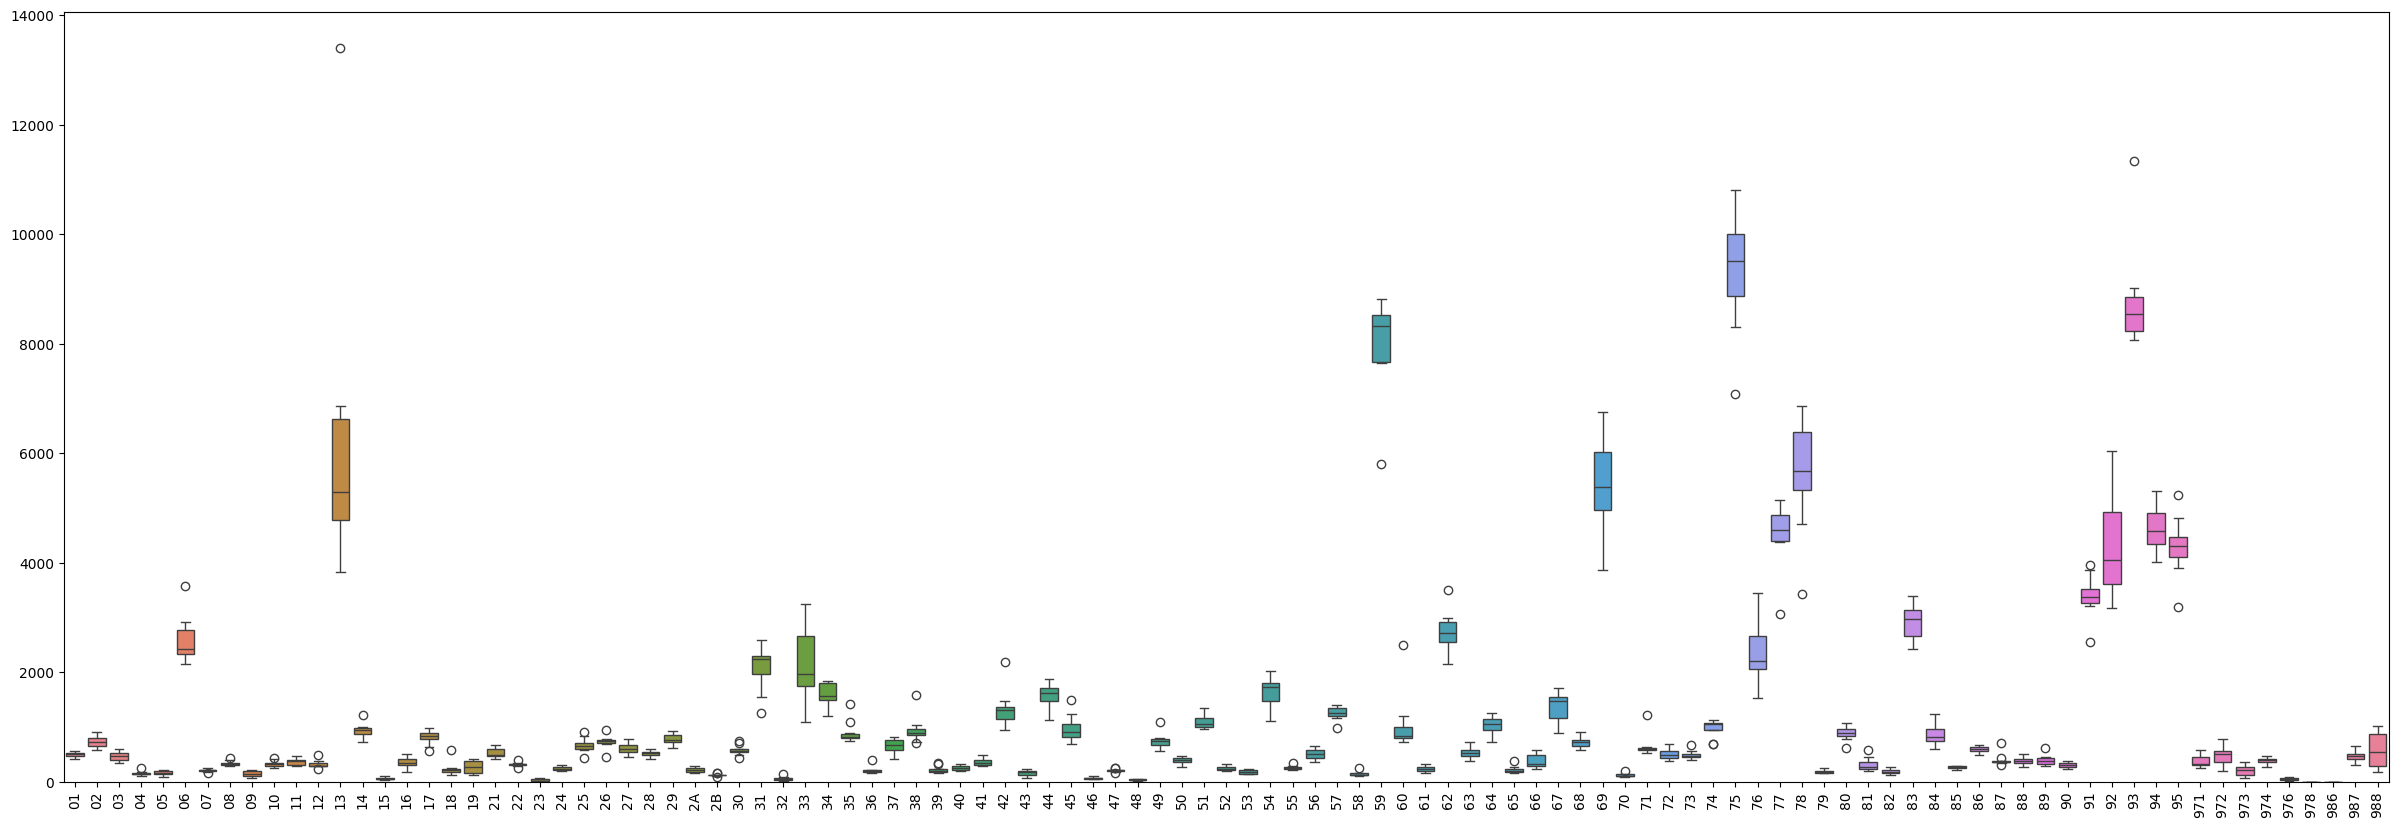

In [1]:
_, ax = plt.subplots(figsize=(30, 10))
sns.boxplot(data=df.drop(['year', 'total'], axis=1)[df['services'] == 'PN'])
plt.xticks(rotation=90)
ax.set(ylim=(0))
plt.show()

In [1]:
df[df['services'] == 'PN'][['year', '13']]

,year,13
0,2012,5168.0
3,2013,6692.0
5,2014,6864.0
7,2015,6405.0
8,2016,5407.0
10,2017,4704.0
13,2018,4349.0
14,2019,3834.0
16,2020,4993.0
18,2021,13394.0


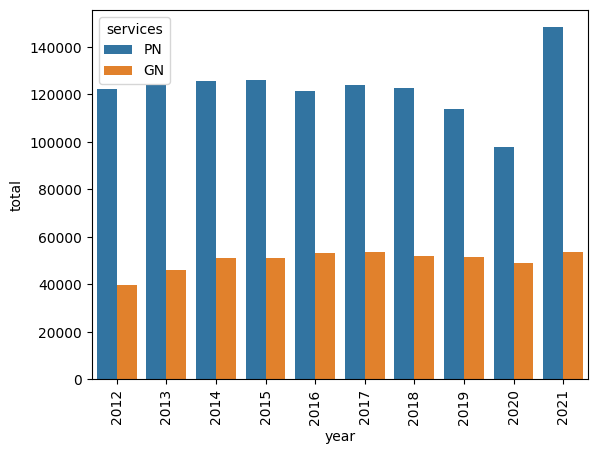

In [1]:
sns.barplot(data=df, x="year", y="total", hue="services", order=sorted(df["year"]))
plt.xticks(rotation=90)
plt.show()

In [1]:
#  GeoJson from French Open-Data (french department)
url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb"
FRANCE_MAP = 'data\contour-des-departements.geojson'

# Read file with geopandas
geo_df = gpd.read_file(FRANCE_MAP)

geo_df['Services PN 2012'] = np.int_
for index, row in geo_df.iterrows():
    geo_df.loc[index, 'Services PN 2012'] = round(df[(df['services'] == 'PN') & (df['year'] == '2012')][row['code']].iloc[0] / df.drop(['year', 'services', 'total'], axis=1)[(df['services'] == 'PN') & (df['year'] == '2012')].max().max(), 3)

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
C:\Users\lolo\AppData\Local\Temp\ipykernel_23092\1656837072.py:3: SyntaxWarning: invalid escape sequence '\c'
  FRANCE_MAP = 'data\contour-des-departements.geojson'


<Axes: >

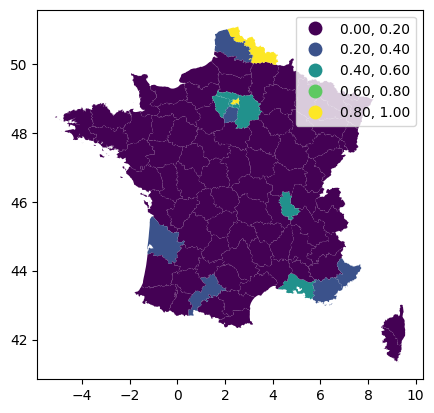

In [1]:
geo_df.plot(column='Services PN 2012', legend=True, scheme="prettybreaks")

In [1]:
df.rename(columns={'year': 'ds', 'total': 'y'}, inplace=True)

In [1]:
df_train = df[(df['ds'] < '2019') & (df['services'] == 'PN')]
df_test = df[( df['ds'] >= '2019') & (df['services'] == 'PN')]

In [1]:
prophet_model = Prophet()
prophet_model.fit(df_train)

In [1]:
#Prédiction
# Nombre de périodes à prédire : 11 mois (pas de données pour décembre 2021)
periods_to_predict = 3
future_crimes = prophet_model.make_future_dataframe(periods=periods_to_predict, freq="Y")
forecast_crimes = prophet_model.predict(df=future_crimes, )

d:\Dev\Python\crimes-delits\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\Dev\Python\crimes-delits\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


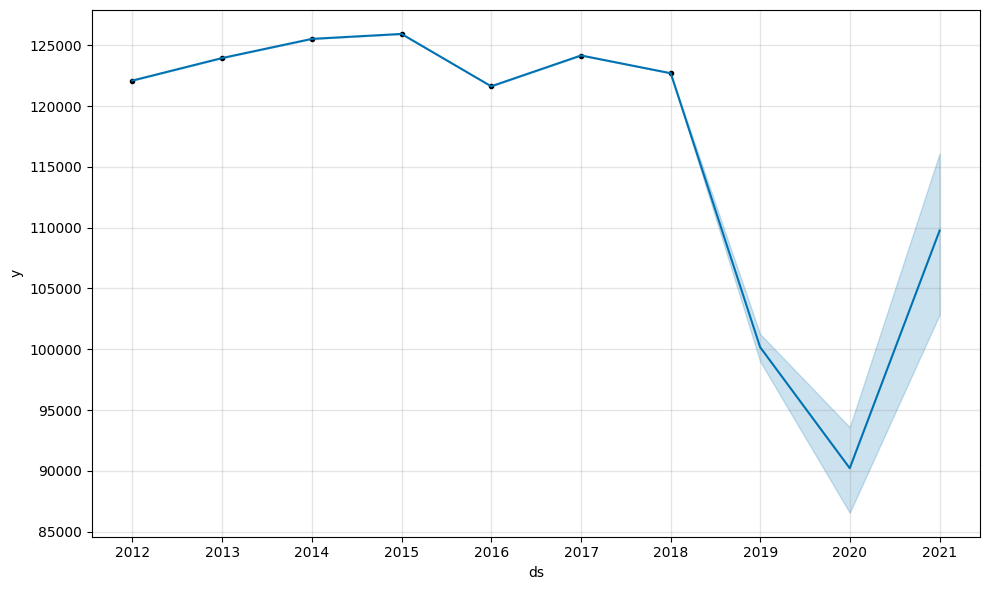

In [1]:
fig=prophet_model.plot(forecast_crimes)

d:\Dev\Python\crimes-delits\.venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
d:\Dev\Python\crimes-delits\.venv\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
d:\Dev\Python\crimes-delits\.venv\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain

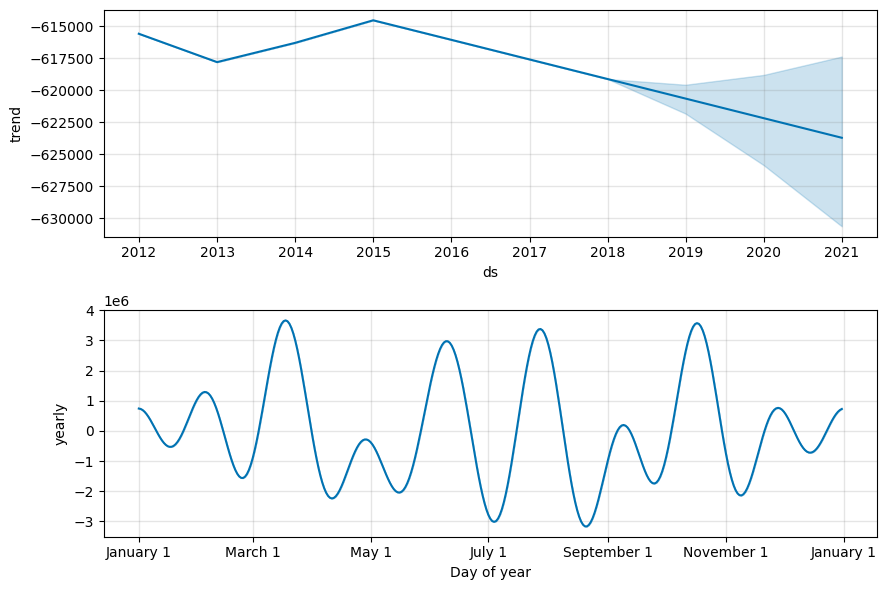

In [1]:
fig = prophet_model.plot_components(forecast_crimes)

In [1]:
df_test

,ds,services,y,01,02,03,04,05,06,07,...,95,971,972,973,974,976,978,986,987,988
14,2019,PN,113920.0,530.0,811.0,341.0,129.0,91.0,2198.0,255.0,...,3902.0,294.0,318.0,111.0,400.0,70.0,0.0,0.0,520.0,804.0
16,2020,PN,97896.0,470.0,602.0,401.0,171.0,196.0,2335.0,149.0,...,3189.0,316.0,189.0,98.0,268.0,45.0,0.0,0.0,334.0,900.0
18,2021,PN,148187.0,545.0,911.0,597.0,255.0,210.0,3579.0,218.0,...,5239.0,468.0,238.0,68.0,377.0,64.0,0.0,0.0,300.0,513.0


In [1]:
# TODO: les dates ds ne s'accorde pas (début/fin d'année)
# meme pb que dans le td
# faire des métriques de la prédiction
forecast_crimes

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,-615587.694480,122099.383738,122099.383751,-615587.694480,-615587.694480,737687.078225,737687.078225,737687.078225,737687.078225,737687.078225,737687.078225,0.0,0.0,0.0,122099.383745
1,2013-01-01,-617804.055660,123954.403751,123954.403764,-617804.055660,-617804.055660,741758.459417,741758.459417,741758.459417,741758.459417,741758.459417,741758.459417,0.0,0.0,0.0,123954.403758
2,2014-01-01,-616299.226113,125528.392016,125528.392029,-616299.226113,-616299.226113,741827.618136,741827.618136,741827.618136,741827.618136,741827.618136,741827.618136,0.0,0.0,0.0,125528.392023
3,2015-01-01,-614537.121354,125933.373034,125933.373047,-614537.121354,-614537.121354,740470.494395,740470.494395,740470.494395,740470.494395,740470.494395,740470.494395,0.0,0.0,0.0,125933.373040
4,2016-01-01,-616060.730603,121626.347615,121626.347629,-616060.730603,-616060.730603,737687.078225,737687.078225,737687.078225,737687.078225,737687.078225,737687.078225,0.0,0.0,0.0,121626.347622
5,2017-01-01,-617595.094115,124163.365296,124163.365309,-617595.094115,-617595.094115,741758.459417,741758.459417,741758.459417,741758.459417,741758.459417,741758.459417,0.0,0.0,0.0,124163.365302
6,2018-01-01,-619125.265377,122702.352753,122702.352766,-619125.265377,-619125.265377,741827.618136,741827.618136,741827.618136,741827.618136,741827.618136,741827.618136,0.0,0.0,0.0,122702.352759
7,2018-12-31,-620651.244389,98998.926606,101249.817279,-621823.677482,-619572.786812,720822.604088,720822.604088,720822.604088,720822.604088,720822.604088,720822.604088,0.0,0.0,0.0,100171.359700
8,2019-12-31,-622181.415650,86545.728462,93585.397729,-625846.294861,-618806.625592,712392.023319,712392.023319,712392.023319,712392.023319,712392.023319,712392.023319,0.0,0.0,0.0,90210.607669
9,2020-12-31,-623715.779162,102845.097289,116109.949797,-630635.173651,-617370.321133,733480.270927,733480.270927,733480.270927,733480.270927,733480.270927,733480.270927,0.0,0.0,0.0,109764.491765


In [1]:
df_test.loc[:, "y_pred"] = forecast_crimes[forecast_crimes.ds >= '2019']["yhat"]

C:\Users\lolo\AppData\Local\Temp\ipykernel_23092\3135331585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, "y_pred"] = forecast_crimes[forecast_crimes.ds >= '2019']["yhat"]


In [1]:
forecast_crimes[forecast_crimes.ds >= '2019']["yhat"]

8     90210.607669
9    109764.491765
Name: yhat, dtype: float64

In [1]:
df_test

,ds,services,y,01,02,03,04,05,06,07,...,971,972,973,974,976,978,986,987,988,y_pred
14,2019,PN,113920.0,530.0,811.0,341.0,129.0,91.0,2198.0,255.0,...,294.0,318.0,111.0,400.0,70.0,0.0,0.0,520.0,804.0,NaN
16,2020,PN,97896.0,470.0,602.0,401.0,171.0,196.0,2335.0,149.0,...,316.0,189.0,98.0,268.0,45.0,0.0,0.0,334.0,900.0,NaN
18,2021,PN,148187.0,545.0,911.0,597.0,255.0,210.0,3579.0,218.0,...,468.0,238.0,68.0,377.0,64.0,0.0,0.0,300.0,513.0,NaN


In [1]:
score_fp = r2_score(df_test["y"], y_pred_fp)
print(f"R² pour les prédictions avec facebook prophet : {score_fp}")

ValueError: Found input variables with inconsistent numbers of samples: [3, 2]

In [1]:
log.debug('End')
log.info('Finished successfully in %.2fs', time.time() - starting_time)

[INFO] 2023-11-27 19:11:40,576 __main__.<module>() 2: Finished successfully in 10.68s
